In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from string import punctuation
import matplotlib.pyplot as plt

In [3]:
stopwords_en = set(stopwords.words('english'))
stopwords_with_punct = stopwords_en.union(set(punctuation))

data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

- I have used sentiment140 dataset from kaggle the problem statement 
- This is a labeled dataset of 1.6 Million tweets
##### data: https://www.kaggle.com/kazanova/sentiment140

In [4]:
data.columns = ('target','uid', 'time', 'query', 'user', 'text')

#### Preprocessing
- In the preprocessing, I have removed all the hastags, @userids, urls as well as punctuation
- Tweets are converted to lowercase, as well as, punctuation has been removed from words
- EG: 'views,'   ---->    'views' 

In [13]:
def preprocess_text(tweet):
    tweet = tweet.lower()
    # remove urls, if any
    tweet = re.sub(r'((https?:\/\/)|(www\.))[A-Za-z0-9.\/]+', '',  tweet)
    tweet = re.sub(r'[A-Za-z0-9]+.com', '',tweet)
    # remove #s, @users, if any
    tweet = re.sub(r'[@#][A-Za-z0-9]+', '',tweet)
    # remove non-ascii characters
    tweet = ''.join([w for w in tweet if ord(w)<128])
    # remove punctuation only
    tweet = ' '.join([w.strip(punctuation) for w in tweet.split() if w not in punctuation])
    # remove stopwords, punctuation
    # do not remove stopwords, sometime tweet becomes meaningless,
    # WE MAY LOOSE IMPORTANT SENTIMENT INFORMATION
#     tweet = [w.strip(punctuation) for w in tweet.lower().split() if w not in stopwords_with_punct]
    # remove words that contains numeric
#     tweet = ' '.join([w for w in tweet if w.isalpha()])
    return tweet

#### select 150 random tweets, 75 from each class
- Due to lack of computational power only 150 tweets has been taken from full dataset
- And on these tweets, a POC has been completed

In [8]:
data['target'].unique()

array([0, 4])

In [5]:
random_data_150 = pd.DataFrame(None, columns=data.columns)

In [9]:
random_data_150 = random_data_150.append(data[data['target']==0].sample(n=75, random_state=1))
random_data_150 = random_data_150.append(data[data['target']==4].sample(n=75, random_state=1))

In [11]:
random_data_150.head(2)

,target,uid,time,query,user,text
670935,0,2246713398,Fri Jun 19 18:00:49 PDT 2009,NO_QUERY,Mickie_1,"@TheRealScarab PA system bugs are a bummer, so..."
649589,0,2237331866,Fri Jun 19 05:36:56 PDT 2009,NO_QUERY,supaflya,oh daaamnnn! the firemen ball's on the 14th an...


In [14]:
%%time
random_data_150['text'] = random_data_150['text'].apply(preprocess_text)

CPU times: user 8.32 ms, sys: 13 µs, total: 8.34 ms
Wall time: 8.21 ms


#### Create Vocabulary
- Vocubulary: is set of unique words appearing in our dataset

In [16]:
combined_sentence = ' '.join([tweet for tweet in random_data_150['text'].values])

In [19]:
vocabulary = set(combined_sentence.split())
len(vocabulary)

849

#### word to index dictionary

In [21]:
word_to_ix = {word:index for index,word in enumerate(vocabulary)}

### Trigram train data

- Trigrams are created by sliding window mechanism
- Eg: Cleaned tweet: pa system bugs are a bummer sorry ;;; Sentiment = negative = 0 = [0,1]
- Below is all possible tupples in following format: ([CONTEXT Words], sentiment)
- (['pa', 'system', 'bugs'], [0, 1]),
- (['system', 'bugs', 'are'], [0, 1]),
- (['bugs', 'are', 'a'], [0, 1]),
- (['are', 'a', 'bummer'], [0, 1]),
- (['a', 'bummer', 'sorry'], [0, 1]),

* positive sentiment in the code is represented as [1,0]


In [113]:
trigrams = []

for index, row in random_data_150.iterrows():
    tweet = row['text']
    sentiment = [0,1] if row['target']==0 else [1,0]
    tweet_grams = []
    tweet = tweet.split()
    for i in range(len(tweet)-2):
        tweet_grams.append(([tweet[i], tweet[i+1], tweet[i+2]], sentiment))
    trigrams.extend(tweet_grams)

In [114]:
trigrams

[(['pa', 'system', 'bugs'], [0, 1]),
 (['system', 'bugs', 'are'], [0, 1]),
 (['bugs', 'are', 'a'], [0, 1]),
 (['are', 'a', 'bummer'], [0, 1]),
 (['a', 'bummer', 'sorry'], [0, 1]),
 (['oh', 'daaamnnn', 'the'], [0, 1]),
 (['daaamnnn', 'the', 'firemen'], [0, 1]),
 (['the', 'firemen', "ball's"], [0, 1]),
 (['firemen', "ball's", 'on'], [0, 1]),
 (["ball's", 'on', 'the'], [0, 1]),
 (['on', 'the', '14th'], [0, 1]),
 (['the', '14th', 'and'], [0, 1]),
 (['14th', 'and', "i'll"], [0, 1]),
 (['and', "i'll", 'still'], [0, 1]),
 (["i'll", 'still', 'be'], [0, 1]),
 (['still', 'be', 'in'], [0, 1]),
 (['be', 'in', 'cannes'], [0, 1]),
 (['in', 'cannes', 'so'], [0, 1]),
 (['cannes', 'so', 'many'], [0, 1]),
 (['so', 'many', 'handsome'], [0, 1]),
 (['many', 'handsome', 'men'], [0, 1]),
 (['handsome', 'men', 'united'], [0, 1]),
 (['men', 'united', '2gether'], [0, 1]),
 (['united', '2gether', 'and'], [0, 1]),
 (['2gether', 'and', 'i'], [0, 1]),
 (['and', 'i', 'miss'], [0, 1]),
 (['i', 'miss', 'it'], [0, 1]),

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

### Trigrams to id tensors
- As every word has an unique index id, saved in word_to_ix dictionary
- I used these ids to uniquely represent word throughout the excercise
- By using these ids,  tensors are created, so that these can be further used in network

In [142]:
trigram_tens = []

for context, target in trigrams:
    context_ids = [word_to_ix[word] for word in context]
    context_tens = torch.tensor(context_ids, dtype=torch.long)
    target_tens = torch.tensor([target], dtype=torch.float)
    trigram_tens.append((context_tens, target_tens))

In [143]:
trigram_tens

[(tensor([670, 773, 597]), tensor([[0., 1.]])),
 (tensor([773, 597, 306]), tensor([[0., 1.]])),
 (tensor([597, 306, 253]), tensor([[0., 1.]])),
 (tensor([306, 253, 635]), tensor([[0., 1.]])),
 (tensor([253, 635, 193]), tensor([[0., 1.]])),
 (tensor([ 98, 627,   7]), tensor([[0., 1.]])),
 (tensor([627,   7, 807]), tensor([[0., 1.]])),
 (tensor([  7, 807, 340]), tensor([[0., 1.]])),
 (tensor([807, 340, 178]), tensor([[0., 1.]])),
 (tensor([340, 178,   7]), tensor([[0., 1.]])),
 (tensor([178,   7, 775]), tensor([[0., 1.]])),
 (tensor([  7, 775,  97]), tensor([[0., 1.]])),
 (tensor([775,  97,  56]), tensor([[0., 1.]])),
 (tensor([ 97,  56, 107]), tensor([[0., 1.]])),
 (tensor([ 56, 107,  87]), tensor([[0., 1.]])),
 (tensor([107,  87, 406]), tensor([[0., 1.]])),
 (tensor([ 87, 406, 506]), tensor([[0., 1.]])),
 (tensor([406, 506, 283]), tensor([[0., 1.]])),
 (tensor([506, 283, 326]), tensor([[0., 1.]])),
 (tensor([283, 326, 364]), tensor([[0., 1.]])),
 (tensor([326, 364, 614]), tensor([[0., 

###  Model
- The model below is created using pytorch framework, with the SSWEh architecture as described in the paper

#### model parameters as used in paper

In [144]:
CONTEXT_LEN = 3
VOCAB_SIZE = len(vocabulary)
EMBEDDING_DIM = 50
HIDDEN_LAYER_LEN = 20
AdagradLearningRate = 0.1

In [145]:
class SSWEh(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_len):
        super(SSWEh, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_len*embedding_dim, HIDDEN_LAYER_LEN)
        self.linear2 = nn.Linear(HIDDEN_LAYER_LEN, 2)
    
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1,-1))
        out = F.hardtanh(self.linear1(embeds))
        out = self.linear2(out)
        return F.softmax(out, dim=1)

## Training

In [146]:
losses = []
loss_function = nn.BCELoss()
model = SSWEh(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_LEN)
optimizer = optim.Adagrad(model.parameters(), lr=AdagradLearningRate)

In [150]:
print(model)

SSWEh(
  (embeddings): Embedding(849, 50)
  (linear1): Linear(in_features=150, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=2, bias=True)
)


In [149]:
loss_function(out1, trigram_tens[0][1])

tensor(0.6428, grad_fn=<BinaryCrossEntropyBackward>)

In [200]:
%%time
for epoch in range(300):
    total_loss = 0
    for context_tens, target_tens in trigram_tens:
        model.zero_grad()
        softmax_out = model(context_tens)
        loss = loss_function(softmax_out, target_tens)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(total_loss)
    losses.append(total_loss)

104.05096202964936
104.01222759109305
103.97092326665282
103.9297038324321
103.88995210208441
103.85397541791173
103.8172011458283
103.78168138056131
103.74717279899227
103.62408524656732
103.61416707392007
103.53002099036283
103.21391336301326
102.85678281755659
101.9160855297821
101.85875012213944
101.7808807277369
101.73258372122311
101.67849404897356
101.26113749585144
100.93042513544168
100.8418887984565
100.80615146609128
100.76276317789836
100.17018864834273
99.44152585509181
99.32060635079117
98.55270712148695
98.89455865616804
94.64308245924923
94.46329550876084
94.3585944617198
94.29029183195601
94.23807436718604
94.19998345616929
94.16006043364487
94.17454699080102
94.14052641422671
93.71733944456324
93.73232561672864
91.88390244079488
91.50767359195726
91.35890765479053
91.29039659135495
91.24614088323659
91.21076371878308
91.17853105456771
91.14882404161469
91.11990978078117
91.09225463013317
91.06565803369088
91.03945538131774
91.00919270951184
90.98007459647081
90.952494

- Training is done twice on the same dataset, 1st time 150 epoch 
- in this case 122 to 104 training loss reduced
- Below is graph for the same

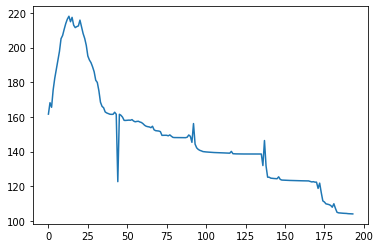

In [156]:
plt.plot(range(len(losses)), losses)

- 2nd time training with 300 epochs 
- here loss coverged from 104 to 85
- Below is graph presented for combined training losses i.e. for case1 + case 2
- so below graph represents 122 to 85 training loss
- in the both cases we clearly see the loss is decreasing, hence network is learning

### Again training for 300 epochs

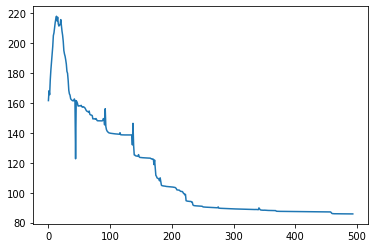

In [201]:
plt.plot(range(len(losses)), losses)

In [204]:
# torch.save(model.state_dict(), 'model.bin')

### Extracting embedding layer from trained model parameters

In [205]:
embed_layer = None
for i in model.parameters():
    embed_layer = i.data
    print(i.data.shape)
    break

torch.Size([849, 50])


- Below is the embedding layer extracted that we trained

In [206]:
embed_layer

tensor([[-0.4797,  0.3074,  0.6980,  ...,  0.7327,  1.3396,  1.0841],
        [-1.0025, -0.4897,  0.2863,  ...,  0.4449, -0.0342,  0.8716],
        [-0.1056, -0.5582, -0.2660,  ...,  1.7791, -1.6851, -0.5330],
        ...,
        [-0.0134, -1.5684, -0.5170,  ...,  2.3509,  1.3668,  0.9529],
        [ 1.5993,  0.2833,  0.6332,  ..., -0.4284,  0.5468,  1.6826],
        [ 0.5372, -0.0716,  0.3283,  ..., -1.4920, -1.9423, -1.1307]])

In [211]:
# torch.save(embed_layer, 'embed_layer_tensor.bin')

#### Visulisation of Embeddings using TSNE
- TSNE is a dimensionality reduction technique
- Our embedding layer is in 849x50 shape, as we had 849 words in our vocubulary
- It will be reduced to 849x2 shape by using TSNE

In [207]:
from sklearn.manifold import TSNE

In [208]:
%%time
tsne = TSNE(n_components=2, random_state=1, n_iter=10000, metric="cosine")
reduced_dim = tsne.fit_transform(embed_layer.numpy())

CPU times: user 27.1 s, sys: 541 ms, total: 27.7 s
Wall time: 11.2 s


In [209]:
reduced_dim

array([[ -1.8074837, -21.83686  ],
       [-14.363697 ,  27.408525 ],
       [ -1.495109 ,   9.154256 ],
       ...,
       [  1.3546674, -24.795744 ],
       [ 23.62765  ,  -8.948303 ],
       [ -9.061972 ,  10.343763 ]], dtype=float32)

In [210]:
reduced_dim.shape

(849, 2)

In [189]:
import seaborn as sns

In [213]:
reduced_we_df = pd.DataFrame(reduced_dim, columns=('x','y'))

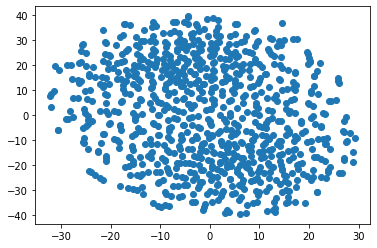

In [214]:
plt.scatter(reduced_we_df['x'], reduced_we_df['y'], )

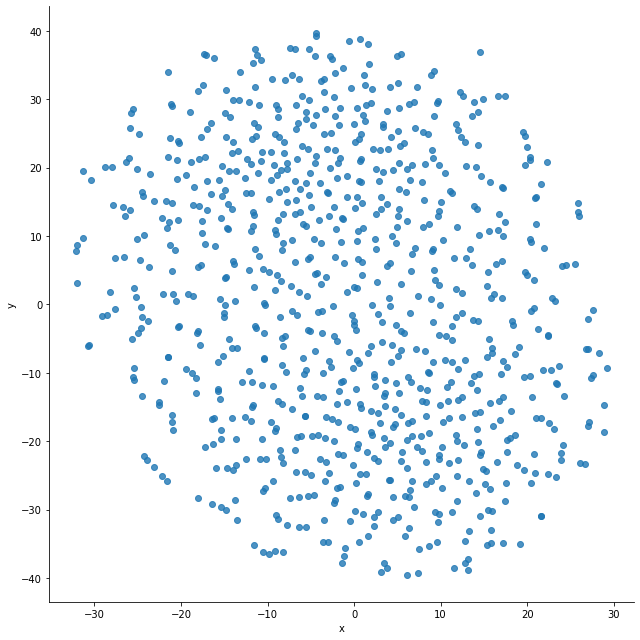

In [215]:
sns.lmplot(x='x', y='y', data=reduced_we_df, fit_reg=False, legend=True, height=9)

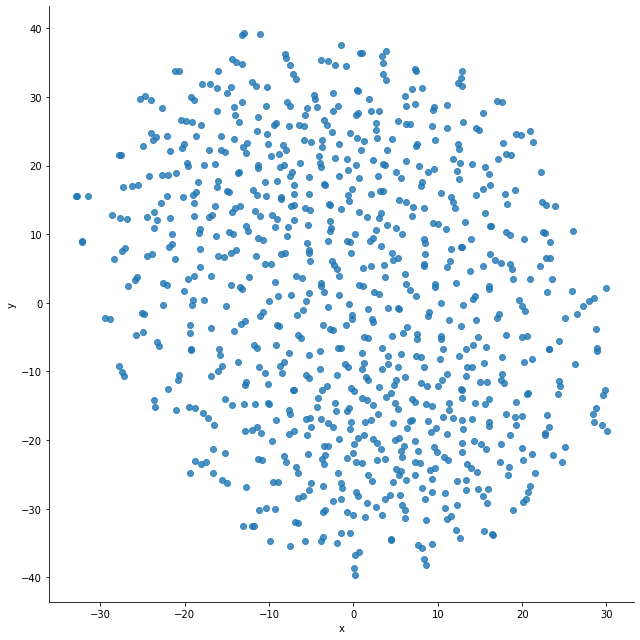

In [191]:
sns.lmplot(x='x', y='y', data=reduced_we_df, fit_reg=False, legend=True, height=9)

### PCA dim reduction

In [216]:
from sklearn.decomposition import PCA

In [217]:
pca = PCA(n_components=2)
pca_reduced = pca.fit_transform(embed_layer.numpy())

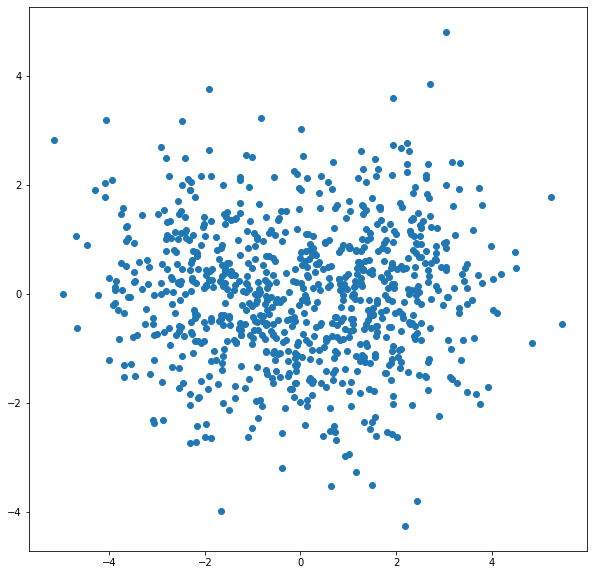

In [221]:
plt.figure(figsize=(10,10))
plt.scatter(pca_reduced[:,0], pca_reduced[:,1])

In [230]:
pd.Series(reduced_dim[:,1]).quantile([0,0.25, 0.5, 0.9, 0.99, 1])

0.00   -39.510647
0.25   -16.629377
0.50    -0.019916
0.90    27.490613
0.99    37.093699
1.00    39.600586
dtype: float64

In [231]:
from sklearn.preprocessing import StandardScaler

In [232]:
sc = StandardScaler()
red_nor = sc.fit_transform(reduced_dim)

In [235]:

pd.Series(red_nor[:,0]).quantile([0,0.25, 0.5, 0.9, 0.99, 1])

0.00   -2.305657
0.25   -0.731125
0.50    0.018143
0.90    1.317593
0.99    2.036551
1.00    2.196119
dtype: float64

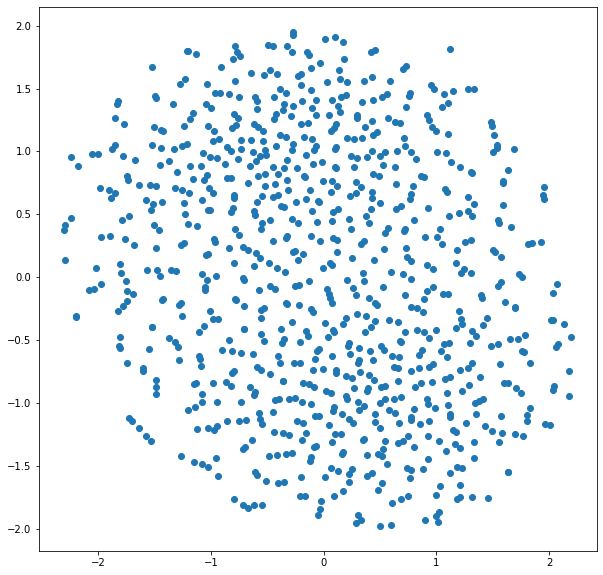

In [236]:
plt.figure(figsize=(10,10))
plt.scatter(red_nor[:,0], red_nor[:,1])

- In both the cases, using pca or tsne, it is expected that the words will form clusters
- However, due to lack of computational power, i took only 150 tweets, with 849 unique words
- This dataset is very less, 
- also we can increase number of epochs in training
- Network architecture could be updated
- Using above methods, certainly we will get clusters because words share common properties or semantics
- And training word embedding would capture these semantics

#### Plotting only particular words from reduced dimension

In [242]:
words = ['sunday', 'tonight', 'tomorrow', 'evening', 'weeks', 'nights', 'night', 'wednesday', 'tuesday', 'monday', 'days', 'weekend', 'friday', 'april', '14th', 'seconds', 'tomm']

In [243]:
len(words)

17

In [244]:
word_indexes = [word_to_ix[word] for word in words]

In [245]:
word_indexes

[238,
 35,
 181,
 13,
 417,
 10,
 754,
 123,
 747,
 489,
 165,
 739,
 823,
 453,
 775,
 27,
 535]

In [250]:
word_vals_by_reduced_embed_layer = reduced_dim[word_indexes, :]

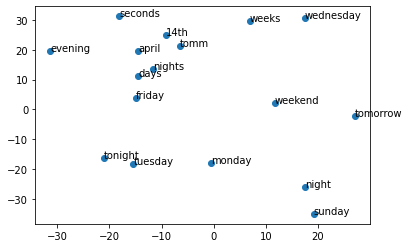

In [264]:
plt.scatter(word_vals_by_reduced_embed_layer[:,0], word_vals_by_reduced_embed_layer[:,1])
for index, word in enumerate(words):
    plt.annotate(word, tuple(word_vals_by_reduced_embed_layer[index]))

(19.21164, -34.950394)